<a href="https://colab.research.google.com/github/a1xsa/machine_learning/blob/main/bank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import numpy as np              # Одномерные и многомерные массивы (array)
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import matplotlib.pyplot as plt # Научная графика
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn                  # Алгоритмы машинного обучения
import os
%matplotlib inline

# **Анализ датасета**

# 1. Загружаем данные


Загружаем файл из репозитория Git, изначально данные разделены на тестовую и обучающую выборку, для первоначального анализа и подготовки данных совместим их в одно целое.

In [64]:
url_train = "https://raw.githubusercontent.com/a1xsa/machine_learning/refs/heads/main/Train.csv"
data_raw_train = pd.read_csv(url_train)
url_test="https://raw.githubusercontent.com/a1xsa/machine_learning/refs/heads/main/Test.csv"
data_raw_test=pd.read_csv(url_test)


In [65]:
data_raw_train.shape

(45211, 17)

In [66]:
data_raw_test.shape

(4521, 17)

In [67]:
data_raw_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [68]:
data_all = pd.concat([data_raw_train, data_raw_test], ignore_index=True)
data_all.shape

(49732, 17)

In [69]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49732 entries, 0 to 49731
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        49732 non-null  int64 
 1   job        49732 non-null  object
 2   marital    49732 non-null  object
 3   education  49732 non-null  object
 4   default    49732 non-null  object
 5   balance    49732 non-null  int64 
 6   housing    49732 non-null  object
 7   loan       49732 non-null  object
 8   contact    49732 non-null  object
 9   day        49732 non-null  int64 
 10  month      49732 non-null  object
 11  duration   49732 non-null  int64 
 12  campaign   49732 non-null  int64 
 13  pdays      49732 non-null  int64 
 14  previous   49732 non-null  int64 
 15  poutcome   49732 non-null  object
 16  y          49732 non-null  object
dtypes: int64(7), object(10)
memory usage: 6.5+ MB


Мы видим что столбцы(признаки) имеют следующие имена:
- `age` - возраст(числовой)
- `job` - работа, категориальный признак ("admin", "unknown","unemployed" "management", "housemaid", "entrepreneur", "student", "blue-collar" "self-employed","retired","technician","services")
- `marital` - семейное положение ("married","divorced","single")
- `education` - образование ("unknown","secondary","primary","tertiary")
- `default` - наличие кредита (бинарный "yes","no")
- `balance` - среднегодовой баланс в евро (числовой)
- `housing` - наличие ипотеки (бинарный "yes","no")
- `loan` - личный кредит (бинарный "yes","no")
- `contact` - тип связи с клиентом ("unknown","telephone","cellular")
- `day` - число последнего контакта с клиентом (числовой)
- `month` - меся последнего контакта с клиентом ("jan", "feb", "mar", …, "nov", "dec")
- `duration` - продолжительность последнего контакта в секундах(числовое)
- `campaign` - количество контактов, выполненных в ходе этой кампании (числовое)
- `pdays` - количество дней, прошедших с момента последнего контакта с клиентом из предыдущей кампании (числовое, -1 - с клианетом ранее не связывались)
- `previous` - количество контактов выполненных до этой кампании
- `poutcome` - результат предыдущей маркетинговой компании ("unknown","other","failure","success")
- `y` - целевой признак, согласие на депозит ("yes", "no")

Требуется предсказать категориальный признак `y` по остальным признакам. Это задача классификации.

In [70]:
data_all.describe()

,age,balance,day,duration,campaign,pdays,previous
count,49732.000000,49732.000000,49732.000000,49732.000000,49732.000000,49732.000000,49732.000000
mean,40.957472,1367.761562,15.816315,258.690179,2.766549,40.158630,0.576892
std,10.615008,3041.608766,8.315680,257.743149,3.099075,100.127123,2.254838
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1431.000000,21.000000,320.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


Приведем все бинарные и категориальные признаки к типу category.

In [71]:
data_all['job'].dtype

dtype('O')

In [72]:
data_all['job'] = data_all['job'].astype('category')
data_all['marital'] = data_all['marital'].astype('category')
data_all['education'] = data_all['education'].astype('category')
data_all['default'] = data_all['default'].astype('category')
data_all['housing'] = data_all['housing'].astype('category')
data_all['loan'] = data_all['loan'].astype('category')
data_all['contact'] = data_all['contact'].astype('category')
data_all['month'] = data_all['month'].astype('category')
data_all['poutcome'] = data_all['poutcome'].astype('category')
data_all['y'] = data_all['y'].astype('category')

In [73]:
data_all['job'].dtype

CategoricalDtype(categories=['admin.', 'blue-collar', 'entrepreneur', 'housemaid',
                  'management', 'retired', 'self-employed', 'services',
                  'student', 'technician', 'unemployed', 'unknown'],
, ordered=False, categories_dtype=object)

Выведем информацию о числовых и категориальных признаках.

In [74]:
data_all.describe()

,age,balance,day,duration,campaign,pdays,previous
count,49732.000000,49732.000000,49732.000000,49732.000000,49732.000000,49732.000000,49732.000000
mean,40.957472,1367.761562,15.816315,258.690179,2.766549,40.158630,0.576892
std,10.615008,3041.608766,8.315680,257.743149,3.099075,100.127123,2.254838
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1431.000000,21.000000,320.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [75]:
data_all.describe(include=['category'])

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,49732,49732,49732,49732,49732,49732,49732,49732,49732,49732
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,10678,30011,25508,48841,27689,41797,32181,15164,40664,43922


# 2. Пропущенные значения:

В качестве пропущенных значений будем также принимать поля "unknown".

In [76]:
data_all.isna().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [77]:
value_counts = data_all.apply(lambda col: col.eq("unknown").sum())
print(value_counts)

age              0
job            326
marital          0
education     2044
default          0
balance          0
housing          0
loan             0
contact      14344
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     40664
y                0
dtype: int64


С пропущенными значениями надо что-то сделать. В качестве обработки неизвестных значений в столбце `poutcome` можно удалить его из рассмотрения в целом. Так же предлагается сделать и со столбцом `contact`. Для признаков `job` и `education` заполним пропущенные значения модой.

In [78]:
data_all['job'].value_counts()

,count
job,
blue-collar,10678
management,10427
technician,8365
admin.,5649
services,4571
retired,2494
self-employed,1762
entrepreneur,1655
unemployed,1431


In [79]:
data_all['job'] = data_all['job'].replace("unknown", data_all['job'].mode().iloc[0])



<ipython-input-79-263ab540e5fd>:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  data_all['job'] = data_all['job'].replace("unknown", data_all['job'].mode().iloc[0])


In [80]:
data_all['job'].value_counts()

,count
job,
blue-collar,11004
management,10427
technician,8365
admin.,5649
services,4571
retired,2494
self-employed,1762
entrepreneur,1655
unemployed,1431


In [81]:
data_all['education'].value_counts()

,count
education,
secondary,25508
tertiary,14651
primary,7529
unknown,2044


In [82]:
data_all['education'] = data_all['education'].replace("unknown", data_all['education'].mode().iloc[0])

<ipython-input-82-91d08fc70c81>:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  data_all['education'] = data_all['education'].replace("unknown", data_all['education'].mode().iloc[0])


In [83]:
data_all['education'].value_counts()

,count
education,
secondary,27552
tertiary,14651
primary,7529


Удалим столбцы с неизвестными значениями.

In [84]:
data_all=data_all.drop(columns=['contact','poutcome'])
value_counts = data_all.apply(lambda col: col.eq("unknown").sum())
print(value_counts)

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
y            0
dtype: int64


In [85]:

data_all.describe(include=['category'])

,job,marital,education,default,housing,loan,month,y
count,49732,49732,49732,49732,49732,49732,49732,49732
unique,11,3,3,2,2,2,12,2
top,blue-collar,married,secondary,no,yes,no,may,no
freq,11004,30011,27552,48841,27689,41797,15164,43922


In [86]:
data_all.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y
0,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,-1,0,no
1,44,technician,single,secondary,no,29,yes,no,5,may,151,1,-1,0,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,-1,0,no
3,47,blue-collar,married,secondary,no,1506,yes,no,5,may,92,1,-1,0,no
4,33,blue-collar,single,secondary,no,1,no,no,5,may,198,1,-1,0,no


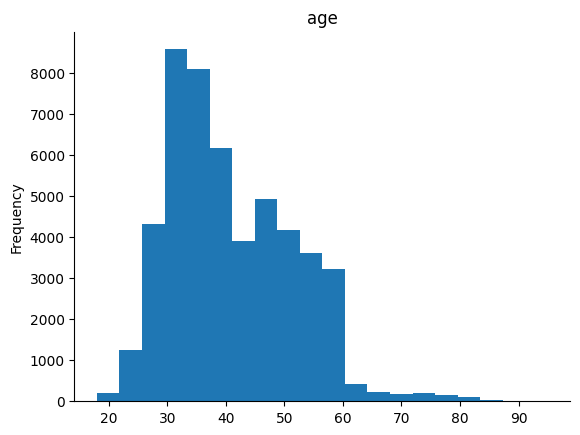

In [87]:
# @title age

from matplotlib import pyplot as plt
data_all['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

# 3. Работа с выбросами.

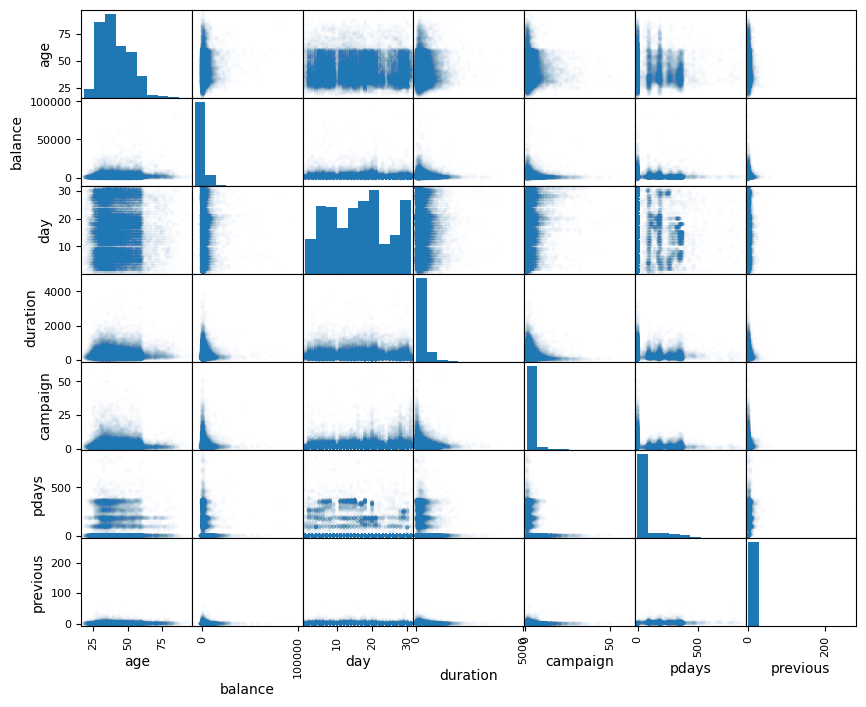

In [62]:
pd.plotting.scatter_matrix(data_all, figsize = (10, 8),alpha=.01)
pass